In [1]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [2]:
#imports
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
class OlivettiFacesDataset(Dataset): #fetching data
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __len__(self): #total number of samples
        return len(self.data)
    
    def __getitem__(self, idx): #applying transform to our data
        image = self.data[idx]
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, target

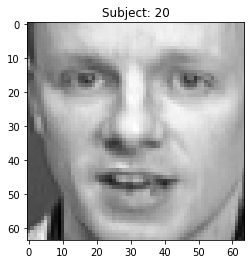

In [4]:
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images
targets = data.target

# Example: Show the first image
plt.imshow(images[0], cmap="gray")
plt.title(f"Subject: {targets[0]}")
plt.show()

In [5]:
data

{'data': array([[0.1983471 , 0.23553719, 0.35123968, ..., 0.06198347, 0.12809917,
         0.09090909],
        [0.18595041, 0.12809917, 0.11570248, ..., 0.19008264, 0.2107438 ,
         0.2107438 ],
        [0.5082645 , 0.60330576, 0.6198347 , ..., 0.33471075, 0.3429752 ,
         0.3429752 ],
        ...,
        [0.61157024, 0.6446281 , 0.6570248 , ..., 0.17768595, 0.2107438 ,
         0.2231405 ],
        [0.28512397, 0.29338843, 0.29752067, ..., 0.53305787, 0.53305787,
         0.5371901 ],
        [0.3264463 , 0.1446281 , 0.2603306 , ..., 0.14049587, 0.30165288,
         0.1570248 ]], dtype=float32),
 'images': array([[[0.1983471 , 0.23553719, 0.35123968, ..., 0.5041322 ,
          0.5289256 , 0.5289256 ],
         [0.19421488, 0.24380165, 0.36363637, ..., 0.5041322 ,
          0.5165289 , 0.5289256 ],
         [0.1983471 , 0.2520661 , 0.35950413, ..., 0.5123967 ,
          0.5123967 , 0.5247934 ],
         ...,
         [0.35950413, 0.57024795, 0.55785125, ..., 0.11570248,
     

In [6]:
print("shape of images: ", images.shape)
print("shape of data matrix: ", data.data.shape)
print("There are {} images in the dataset.".format(images.shape[0]))
print("There are {} unique targets in the dataset.".format(len(np.unique(targets))))
print("No need to normalize as it is already between 0 and 1")

shape of images:  (400, 64, 64)
shape of data matrix:  (400, 4096)
There are 400 images in the dataset.
There are 40 unique targets in the dataset.
No need to normalize as it is already between 0 and 1


In [9]:
images_reshaped = images.reshape(-1, 1, 64, 64)
X_train, X_test, y_train, y_test = train_test_split(images_reshaped, targets, test_size=0.2, random_state=42)

# Create a DataLoader without normalization to compute mean and std
compute_loader = DataLoader(OlivettiFacesDataset(X_train, y_train, transform=transforms.ToTensor()), batch_size=4, shuffle=False)
print("X_train's shape:",X_train.shape)
print("X_test's shape:",X_test.shape)
print("y_train's shape:",y_train.shape)
print("y_test's shape:",y_train.shape)

X_train's shape: (320, 1, 64, 64)
X_test's shape: (80, 1, 64, 64)
y_train's shape: (320,)
y_test's shape: (320,)


In [10]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

mean, std = get_mean_std(compute_loader)
print("Mean:", mean)
print("Std:", std)


Mean: tensor(0.1363)
Std: tensor(0.0396)


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), #Converts images to Pytorch Tensors
    transforms.Normalize((mean), (std))  # Normalizes tensors to have calculated mean and standard deviations.
])

In [12]:
train_dataset = OlivettiFacesDataset(X_train, y_train, transform=transform)
#Use num_workers =0 by default due to small size of dataset

trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = OlivettiFacesDataset(X_test, y_test, transform=transform)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=False)